In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def tensor_product(x,y,op):
    """
    tensor products in tensorflow
    x,y are tensors in a graph
    op is an elementwise binary operation
    
    example:
    if x[i,j,k] and y[p,q] are tensors in a graph, then tensor_product(x,y,tf.mul) returns
    z[i,j,k,p,q] = x[i,j,k] y[p,q]
    
    """
    shape_x = tf.shape(x)
    shape_y = tf.shape(y)
    new_shape_x = tf.concat(0,[shape_x,tf.ones_like(shape_y,dtype = tf.int32)])
    new_shape_y = tf.concat(0,[tf.ones_like(shape_x,dtype = tf.int32),shape_y])
    x_reshaped = tf.reshape(x,new_shape_x)
    y_reshaped = tf.reshape(y,new_shape_y)
    return op(x_reshaped,y_reshaped)

In [4]:
def K_mean_clustering(K,D,data,iterations):
    """
    K is the number of clusters
    D is the dimension of the space in which the data points live
    iterations is the number of times the means and labels are update
    the algorithm is taken from chapter 20 of Mackay's book
    data is a N x D array
    """
    graph = tf.Graph()
    
    mean_init = np.float32(np.random.normal(size = [K,D])) + location_data.mean(axis=0).reshape(1,D) # K x D array
    
    with graph.as_default():
        x = tf.placeholder(tf.float32,shape = [None,D])
        means = tf.Variable(tf.constant(mean_init))
        
        means_outer_minus_x = tf.batch_matrix_diag_part(tf.transpose(tensor_product(means,x,tf.sub),
                                                                     perm = [2,0,1,3]))
        
        distance_matrix = tf.reduce_sum(tf.square(means_outer_minus_x),2)
        k = tf.argmin(distance_matrix,1)
        r = tf.one_hot(k,K,on_value = 1.0, off_value = 0.0,dtype = tf.float32)
        R = tf.reduce_sum(r,0)
        
        new_means_unnormalized = tf.reduce_sum(tf.batch_matrix_diag_part(tf.transpose(tensor_product(r,x,tf.mul),
                                                                                      perm = [1,3,0,2])),
                                               2)
        
        new_means_unnormalized = tf.select(tf.greater(R,0),new_means_unnormalized,means)
        R_plus = tf.select(tf.greater(R,0),R,R+1)
        new_means = new_means_unnormalized / tf.reshape(R_plus,[tf.size(R_plus),1])
        update = means.assign(new_means)
        
    with tf.Session(graph = graph) as sess:
        sess.run(tf.initialize_all_variables())
        for step in range(iterations):
            sess.run(update,feed_dict = {x : data})
            
        output_means = sess.run(means,feed_dict= {x : data})
        output_labels = sess.run(r,feed_dict= {x : data})
    
    return output_means, output_labels

In [5]:
fiji_data = pd.read_table("../practice_data_sets/small_datasets/wasserman/fijiquakes.dat",delim_whitespace=True).drop(["Obs.","depth","mag","stations"],axis=1)
location_data = np.float32(fiji_data.values)

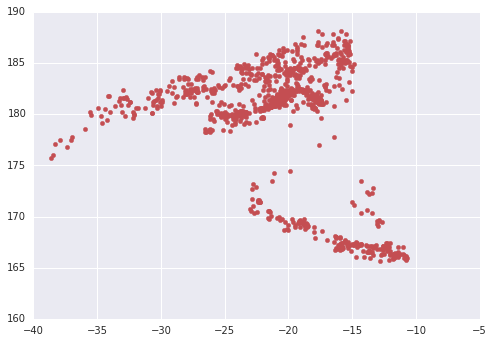

In [6]:
colors = sns.color_palette()
plt.scatter(location_data[:,0],location_data[:,1],color = colors[2])
plt.show()

In [7]:
means,labels_hot_one = K_mean_clustering(2,2,location_data,20)

In [8]:
labels = labels_hot_one[:,0]

In [9]:
label_0 = np.array([location_data[i] for i in range(1000) if labels[i] == 0])
label_1 = np.array([location_data[i] for i in range(1000) if labels[i] == 1])

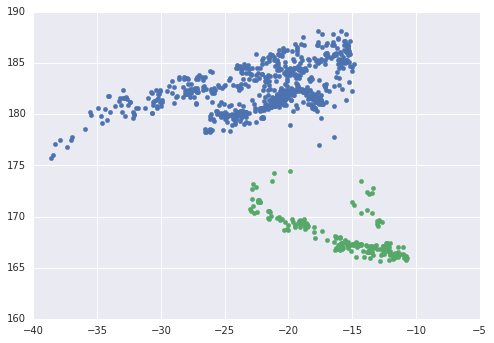

In [10]:
colors = sns.color_palette()
plt.scatter(label_0[:,0],label_0[:,1],color = colors[0])
plt.scatter(label_1[:,0],label_1[:,1],color = colors[1])
plt.show()